<a href="https://colab.research.google.com/github/srirampai/Active_learning/blob/main/IMDB_V2_active_learning_review_classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing required libraries

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import re
import string

tfds.disable_progress_bar()

## Loading and preprocessing the data

We will be using the IMDB reviews dataset for our experiments. This dataset has 50,000
reviews in total, including training and testing splits. We will merge these splits and
sample our own, balanced training, validation and testing sets.

In [ ]:
dataset = tfds.load(
    "imdb_reviews",
    split="train + test",
    as_supervised=True,
    batch_size=-1,
    shuffle_files=False,
)
reviews, labels = tfds.as_numpy(dataset)

print("Total examples:", reviews.shape[0])

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteZBMNQN/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteZBMNQN/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteZBMNQN/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Total examples: 50000


In [ ]:
print(type(reviews))
print(type(labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Active learning starts with labeling a subset of data.
For the ratio sampling technique that we will be using, we will need well-balanced training,
validation and testing splits.

In [ ]:
#Defining the Split
val_split = 2500
test_split = 2500
train_split = 7500

# Separating the negative and positive samples for manual stratification
x_positives, y_positives = reviews[labels == 1], labels[labels == 1]
x_negatives, y_negatives = reviews[labels == 0], labels[labels == 0]

# Creating training, validation and testing splits
x_val, y_val = (
    tf.concat((x_positives[:val_split], x_negatives[:val_split]), 0),
    tf.concat((y_positives[:val_split], y_negatives[:val_split]), 0),
)
x_test, y_test = (
    tf.concat(
        (
            x_positives[val_split : val_split + test_split],
            x_negatives[val_split : val_split + test_split],
        ),
        0,
    ),
    tf.concat(
        (
            y_positives[val_split : val_split + test_split],
            y_negatives[val_split : val_split + test_split],
        ),
        0,
    ),
)
x_train, y_train = (
    tf.concat(
        (
            x_positives[val_split + test_split : val_split + test_split + train_split],
            x_negatives[val_split + test_split : val_split + test_split + train_split],
        ),
        0,
    ),
    tf.concat(
        (
            y_positives[val_split + test_split : val_split + test_split + train_split],
            y_negatives[val_split + test_split : val_split + test_split + train_split],
        ),
        0,
    ),
)

# Remaining pool of samples are stored separately. These are only labeled as and when required
x_pool_positives, y_pool_positives = (
    x_positives[val_split + test_split + train_split :],
    y_positives[val_split + test_split + train_split :],
)
x_pool_negatives, y_pool_negatives = (
    x_negatives[val_split + test_split + train_split :],
    y_negatives[val_split + test_split + train_split :],
)

# Creating TF Datasets for faster prefetching and parallelization
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

pool_negatives = tf.data.Dataset.from_tensor_slices(
    (x_pool_negatives, y_pool_negatives)
)
pool_positives = tf.data.Dataset.from_tensor_slices(
    (x_pool_positives, y_pool_positives)
)

print(f"Initial training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Testing set size: {len(test_dataset)}")
print(f"Unlabeled negative pool: {len(pool_negatives)}")
print(f"Unlabeled positive pool: {len(pool_positives)}")

Initial training set size: 15000
Validation set size: 5000
Testing set size: 5000
Unlabeled negative pool: 12500
Unlabeled positive pool: 12500


### Fitting the `TextVectorization` layer

Since we are working with text data, we will need to encode the text strings as vectors which
would then be passed through an `Embedding` layer. To make this tokenization process
faster, we use the `map()` function with its parallelization functionality.

In [ ]:

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )

# Using Tensorflow inbuilt 
vectorizer = layers.TextVectorization(
    3000, standardize=custom_standardization, output_sequence_length=150
)
# Adapting the dataset
vectorizer.adapt(
    train_dataset.map(lambda x, y: x, num_parallel_calls=tf.data.AUTOTUNE).batch(256)
)


def vectorize_text(text, label):
    text = vectorizer(text)
    return text, label


train_dataset = train_dataset.map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)
pool_negatives = pool_negatives.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
pool_positives = pool_positives.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(256).map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
)
test_dataset = test_dataset.batch(256).map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
)

## Creating Helper Functions

In [ ]:
# Helper function for merging new history objects with older ones
def append_history(losses, val_losses, accuracy, val_accuracy, history):
    losses = losses + history.history["loss"]
    val_losses = val_losses + history.history["val_loss"]
    accuracy = accuracy + history.history["binary_accuracy"]
    val_accuracy = val_accuracy + history.history["val_binary_accuracy"]
    return losses, val_losses, accuracy, val_accuracy


# Plotter function
def plot_history(losses, val_losses, accuracies, val_accuracies):
    plt.plot(losses)
    plt.plot(val_losses)
    plt.legend(["train_loss", "val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.plot(accuracies)
    plt.plot(val_accuracies)
    plt.legend(["train_accuracy", "val_accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()


## Creating the Model

We create a small bidirectional LSTM model. When using Active Learning, you should make sure
that the model architecture is capable of overfitting to the initial data.
Overfitting gives a strong hint that the model will have enough capacity for
future, unseen data.

In [ ]:
# Incearing the depth
def create_model():
    model = keras.models.Sequential(
        [
            layers.Input(shape=(150,)),
            layers.Embedding(input_dim=3000, output_dim=128),
            layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
            layers.GlobalMaxPool1D(),
            #layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
            #layers.GlobalMaxPool1D(),         
            layers.Dense(20, activation="relu"),
            layers.Dropout(0.5),
            layers.Dense(1, activation="sigmoid"),
        ]
    )
    model.summary()
    return model


In [ ]:
model = create_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 128)          384000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 150, 128)         98816     
 nal)                                                            
                                                                 
 global_max_pooling1d_3 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 20)                2580      
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

## **Active Learning**




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 128)          384000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 150, 128)         98816     
 nal)                                                            
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 20)                2580      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

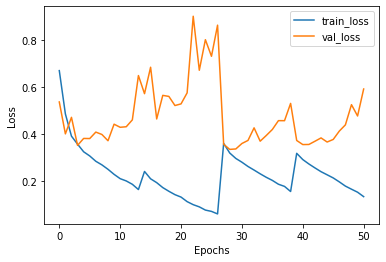

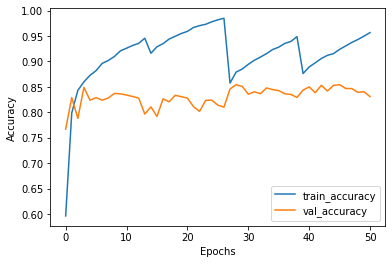

----------------------------------------------------------------------------------------------------
Test set evaluation:  {'loss': 0.34319737553596497, 'binary_accuracy': 0.848800003528595, 'false_negatives_2': 420.0, 'false_positives_2': 336.0, 'precision_2': 0.860927164554596, 'recall_2': 0.8320000171661377, 'true_positives_2': 2080.0, 'true_negatives_2': 2164.0, 'auc_2': 0.9281008839607239}
----------------------------------------------------------------------------------------------------


In [ ]:

def train_active_learning_models(
    train_dataset,
    pool_negatives,
    pool_positives,
    val_dataset,
    test_dataset,
    num_iterations=3,
    sampling_size=5000,
):

    # Creating lists for storing metrics
    losses, val_losses, accuracies, val_accuracies = [], [], [], []

    model = create_model()
    # We will monitor the false positives and false negatives predicted by our model
    # These will decide the subsequent sampling ratio for every Active Learning loop
    model.compile(
        loss="binary_crossentropy",
        optimizer="rmsprop",
        metrics=[
            keras.metrics.BinaryAccuracy(),
            keras.metrics.FalseNegatives(),
            keras.metrics.FalsePositives(),
            keras.metrics.Precision(),
            keras.metrics.Recall(),
            keras.metrics.TruePositives(),
            keras.metrics.TrueNegatives(),
            keras.metrics.AUC()
        ],
    )

    # Defining checkpoints.
    # The checkpoint callback is reused throughout the training since it only saves the best overall model.
    checkpoint = keras.callbacks.ModelCheckpoint(
        "AL_Model.h5", save_best_only=True, verbose=1
    )
    # Here, patience is set to 10. This can be set higher if desired.
    early_stopping = keras.callbacks.EarlyStopping(patience=10, verbose=1)

    print(f"Starting to train with {len(train_dataset)} samples")
    # Initial fit with a small subset of the training set
    history = model.fit(
        train_dataset.cache().shuffle(20000).batch(256),
        epochs=15,
        validation_data=val_dataset,
        callbacks=[checkpoint, early_stopping],
    )

    # Appending history
    losses, val_losses, accuracies, val_accuracies = append_history(
        losses, val_losses, accuracies, val_accuracies, history
    )

    for iteration in range(num_iterations):
        # Getting predictions from previously trained model
        predictions = model.predict(test_dataset)

        # Generating labels from the output probabilities
        rounded = tf.where(tf.greater(predictions, 0.5), 1, 0)

        # Evaluating the number of zeros and ones incorrrectly classified
        _, _, false_negatives, false_positives, precision, recall, true_postives, true_negatives, auc= model.evaluate(test_dataset, verbose=0)

        print("-" * 100)
        print(
            f"Number of zeros incorrectly classified: {false_negatives}, Number of ones incorrectly classified: {false_positives}"
        )

        # This technique of Active Learning demonstrates ratio based sampling where
        # Number of ones/zeros to sample = Number of ones/zeros incorrectly classified / Total incorrectly classified
        if false_negatives != 0 and false_positives != 0:
            total = false_negatives + false_positives
            sample_ratio_ones, sample_ratio_zeros = (
                false_positives / total,
                false_negatives / total,
            )
        # In the case where all samples are correctly predicted, we can sample both classes equally
        else:
            sample_ratio_ones, sample_ratio_zeros = 0.5, 0.5

        print(
            f"Sample ratio for positives: {sample_ratio_ones}, Sample ratio for negatives:{sample_ratio_zeros}"
        )

        # Sample the required number of ones and zeros
        sampled_dataset = pool_negatives.take(
            int(sample_ratio_zeros * sampling_size)
        ).concatenate(pool_positives.take(int(sample_ratio_ones * sampling_size)))

        # Skip the sampled data points to avoid repetition of sample
        pool_negatives = pool_negatives.skip(int(sample_ratio_zeros * sampling_size))
        pool_positives = pool_positives.skip(int(sample_ratio_ones * sampling_size))

        # Concatenating the train_dataset with the sampled_dataset
        train_dataset = train_dataset.concatenate(sampled_dataset).prefetch(
            tf.data.AUTOTUNE
        )

        print(f"Starting training with {len(train_dataset)} samples")
        print("-" * 100)

        # We recompile the model to reset the optimizer states and retrain the model
        model.compile(
            loss="binary_crossentropy",
            optimizer="rmsprop",
            metrics=[
                keras.metrics.BinaryAccuracy(),
                keras.metrics.FalseNegatives(),
                keras.metrics.FalsePositives(),
                keras.metrics.Precision(),
                keras.metrics.Recall(),
                keras.metrics.TruePositives(),
                keras.metrics.TrueNegatives(),
                keras.metrics.AUC()
            ],
        )
        history = model.fit(
            train_dataset.cache().shuffle(20000).batch(256),
            validation_data=val_dataset,
            epochs=20,
            callbacks=[
                checkpoint,
                keras.callbacks.EarlyStopping(patience=10, verbose=1),
            ],
        )

        # Appending the history
        losses, val_losses, accuracies, val_accuracies = append_history(
            losses, val_losses, accuracies, val_accuracies, history
        )

        # Loading the best model from this training loop
        model = keras.models.load_model("AL_Model.h5")

    # Plotting the overall history and evaluating the final model
    plot_history(losses, val_losses, accuracies, val_accuracies)
    print("-" * 100)
    print(
        "Test set evaluation: ",
        model.evaluate(test_dataset, verbose=0, return_dict=True),
    )
    print("-" * 100)

    return model


active_learning_model = train_active_learning_models(
    train_dataset, pool_negatives, pool_positives, val_dataset, test_dataset
)

## Conclusion


The following are some  observations from this excerise:

1. We only require 30,000 samples to reach the same (if not better) scores as the model
trained on the full datatset. This means that in a real life setting, we save the effort
required for annotating 10,000 images!
2. The number of false negatives and false positives are well balanced at the end of the
training as compared to the skewed ratio obtained from the full training. This makes the
model slightly more useful in real life scenarios where both the labels hold equal
importance.

